# Noise issue

In [1]:
import matplotlib.pyplot as plt
import scipy
import numpy as np
from ldc.lisa.noise import get_noise_model
from lisainstrument import Instrument
import pytdi
from pytdi.michelson import X2, Y2, Z2
from pytdi import Data
import logging
from lisainstrument.containers import ForEachMOSA
from ldc.common.tools import window

In [2]:
logger = logging.getLogger('lisainstrument')
logger.setLevel(logging.INFO)

dt_instru = 0.25
physics_upsampling = 1
dt_physic = dt_instru/physics_upsampling

central_freq = 2.816E14
aafilter = None
            
N = 120960      
        
i = Instrument(physics_upsampling=physics_upsampling, aafilter=aafilter, size=N, dt=dt_instru, central_freq=central_freq)
i.disable_all_noises(but="pathlength")
i.disable_dopplers()
i.simulate()

data = Data.from_instrument(i)
data.delay_derivative = None

In [3]:
built = X2.build(**data.args_nodoppler)
X2_data = built(data.measurements)/central_freq

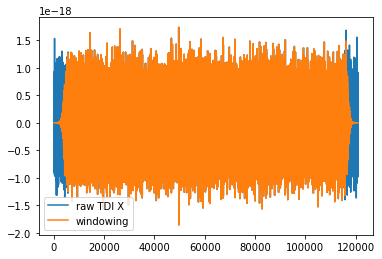

In [4]:
win = window(i.t, xl=1000)
plt.figure()
plt.plot(X2_data, label='raw TDI X')
plt.plot(X2_data*win, label="windowing")
plt.legend()

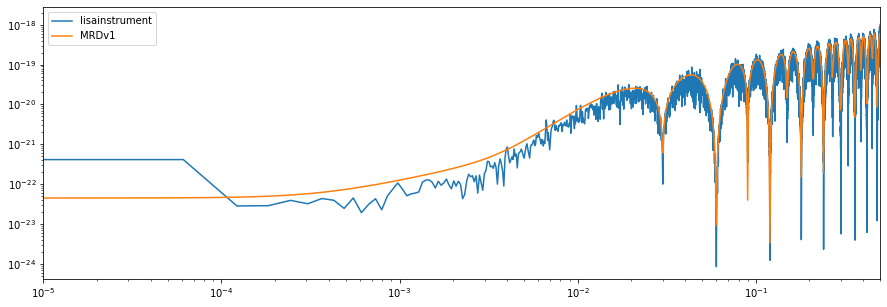

In [5]:
noise_model = "MRDv1"
freq = np.logspace(-5, 0, 1000)
Nmodel = get_noise_model(noise_model, freq)
Npsd = Nmodel.psd(tdi2=True, option="X", freq=freq)
f, psdX =  scipy.signal.welch(X2_data*win, fs=1.0/dt_instru, window='hanning', nperseg=256*256)
plt.figure(figsize=(15,5))
plt.loglog(f, np.sqrt(psdX), label="lisainstrument")
plt.loglog(freq, np.sqrt(Npsd), label=noise_model)
plt.axis([1e-5, 0.5, None, None])#1e-21, 1e-18])
plt.legend()

## Filtering for downsampling

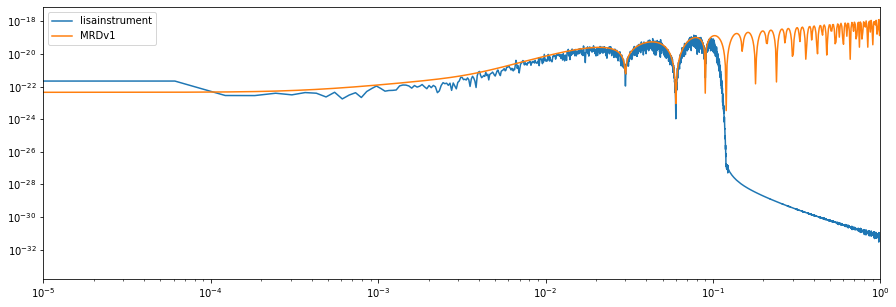

In [19]:
from scipy import signal
attenuation = 240
freq1 = 0.05
freq2 = 0.1
df = 1/dt_instru
numtaps, beta = signal.kaiserord(attenuation, (freq2 - freq1) / (df/2.))
filter_coeff = signal.firwin(numtaps, 0.05, window=('kaiser', beta))
X_data = signal.lfilter(filter_coeff, 1, X2_data)
f, psdX =  scipy.signal.welch(X_data*win, fs=1.0/dt_instru, window='hanning', nperseg=256*256)
plt.figure(figsize=(15,5))
plt.loglog(f, np.sqrt(psdX), label="lisainstrument")
plt.loglog(freq, np.sqrt(Npsd), label=noise_model)
plt.axis([1e-5, 1e0, None, None])#1e-21, 1e-18])
plt.legend()

# Downsampling

We try first dt=0.25s -> dt=2.5s

0.4


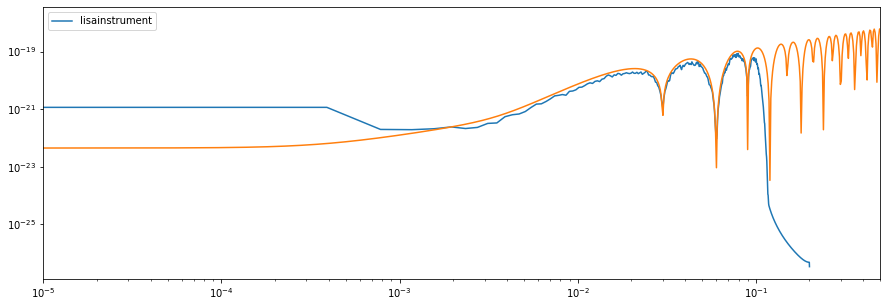

In [20]:
step = 10
data_ds = (X_data)[0:-1:step]
tvec = i.t[0:-1:step]
#data_ds = scipy.interpolate.InterpolatedUnivariateSpline(i.t, X_data, k=1)(tvec)
fs = 1/(tvec[1]-tvec[0])
print(fs)
plt.figure(figsize=(15,5))
f, psdX =  scipy.signal.welch(data_ds, fs=fs, window='hanning', nperseg=32*32)
plt.loglog(f, np.sqrt(psdX), label="lisainstrument")
plt.loglog(freq, np.sqrt(Npsd))
plt.axis([1e-5, 0.5, None, None])#1e-21, 1e-18])
plt.legend()

Then we try dt=0.25s -> dt=5s

0.2


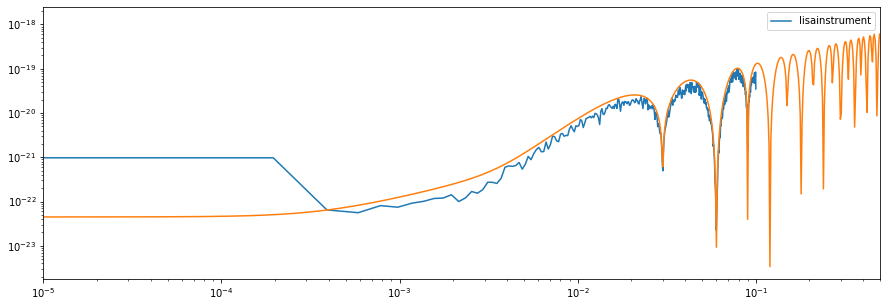

In [21]:
step = 20
data_ds = (X_data)[0:-1:step]
tvec = i.t[0:-1:step]
#data_ds = scipy.interpolate.InterpolatedUnivariateSpline(i.t, X_data, k=1)(tvec)
fs = 1/(tvec[1]-tvec[0])
print(fs)
plt.figure(figsize=(15,5))
f, psdX =  scipy.signal.welch(data_ds, fs=fs, window='hanning', nperseg=32*32)
plt.loglog(f, np.sqrt(psdX), label="lisainstrument")
plt.loglog(freq, np.sqrt(Npsd))
plt.axis([1e-5, 0.5, None, None])#1e-21, 1e-18])
plt.legend()